# **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Embedding, Concatenate, Bidirectional, AdditiveAttention
from keras.utils.vis_utils import plot_model
from keras import backend as K 

# **Read and Load File**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-06-09 03:21:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-09 03:21:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-09 03:21:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
GLOVE_PATH = 'glove.6B.300d.txt'

In [ ]:
df = pd.read_csv('Mental_Health_FAQ.csv')

In [ ]:
df.drop('Question_ID', axis=1, inplace=True)

In [ ]:
stopwords = []
with open('stopwords.txt', encoding='utf-8') as f:
  for line in f:
    stopwords.append(line.strip())

# **PreProcessing**

In [ ]:
def remove_stopwords(df):
  df = df.apply(lambda w: " ".join([x for x in w.lower().split() if x not in stopwords]))
  return df

In [ ]:
def remove_punctuation(df):
  df = df.apply(lambda w: " ".join([re.sub('[.,’"\'-?:!;()*%]', '', x) for x in w.split()]))
  return df

In [ ]:
def normalize_text(df):
  df = df.apply(lambda w: " ".join([x.encode("ascii", "ignore").decode() for x in w.split()])) 
  return df

In [ ]:
df['Questions'] = remove_punctuation(df['Questions'])
df['Answers'] = remove_punctuation(df['Answers'])

In [ ]:
df['Answers'] = normalize_text(df['Answers'])
df['Questions'] = normalize_text(df['Questions'])

In [ ]:
# df['Questions'] = remove_stopwords(df['Questions'])

In [ ]:
df['Answers'] = "<START> " + df['Answers'] + " <END>"

In [ ]:
questions_max_len = max([len(x.split()) for x in df['Questions']])
answers_max_len = max([len(x.split()) for x in df['Answers']])

# **Train Test Split**

In [ ]:
# train_data, test_data, train_label, test_label = train_test_split(df['Questions'], df['Answers'], train_size = 0.7, random_state = 11, shuffle = True)

# **Tokenizing And Padding**

Questions

In [ ]:
questions_tokenizer = Tokenizer(oov_token='<OOV>')
questions_tokenizer.fit_on_texts(df['Questions'])
questions_totalWords = len(questions_tokenizer.word_index) + 1

train_data = questions_tokenizer.texts_to_sequences(df['Questions'])
# test_data = questions_tokenizer.texts_to_sequences(test_data)

train_data = pad_sequences(train_data, maxlen=questions_max_len, padding='post')
# test_data = pad_sequences(test_data, maxlen=questions_max_len, padding='post')

In [ ]:
questions_totalWords

258

Answers

In [ ]:
answers_tokenizer = Tokenizer(oov_token='<OOV>')
answers_tokenizer.fit_on_texts(df['Answers'])
answers_totalWords = len(answers_tokenizer.word_index) + 1

train_label = answers_tokenizer.texts_to_sequences(df['Answers'])
# test_label = answers_tokenizer.texts_to_sequences(test_label)

train_label = pad_sequences(train_label, maxlen=answers_max_len, padding='post')
# test_label = pad_sequences(test_label, maxlen=answers_max_len, padding='post')

In [ ]:
answers_totalWords

2796

# **GLOve Word Embedding**

In [ ]:
GLOVE_EMBEDDINGS = {}

with open(GLOVE_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
EMBEDDINGS_MATRIX_QUESTIONS = np.zeros((questions_totalWords, 300))

for word, i in questions_tokenizer.word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX_QUESTIONS[i] = embedding_vector

In [ ]:
EMBEDDINGS_MATRIX_ANSWERS = np.zeros((answers_totalWords, 300))

for word, i in answers_tokenizer.word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX_ANSWERS[i] = embedding_vector

# **Callback**

In [ ]:
class Callback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.99:
            self.model.stop_training = True

# **Model Attention**

In [ ]:
# K.clear_session() 
# latent_dim = 300 

# # Encoder 
# encoder_inputs = Input(shape=(questions_max_len,)) 
# enc_emb = Embedding(questions_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_QUESTIONS])(encoder_inputs) 
# enc_emb = Dropout(0.5)(enc_emb)

# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb) 

# # Decoder. 
# decoder_inputs = Input(shape=(None,)) 
# dec_emb_layer = Embedding(answers_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_ANSWERS])(decoder_inputs) 
# dec_emb_layer = Dropout(0.5)(dec_emb_layer)

# encoder_states = [state_h, state_c]

# decoder_lstm = LSTM(latent_dim, return_sequences=True)
# decoder_outputs = decoder_lstm(dec_emb_layer,initial_state=encoder_states) 

# # Attention Layer
# attn_out = AdditiveAttention(512)([decoder_outputs, encoder_outputs]) 
# decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])

# # Dense layer
# decoder_dense = TimeDistributed(Dense(answers_totalWords, activation='softmax')) 
# decoder_outputs = decoder_dense(decoder_concat_input) 

# # Define the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
# model.summary()

# **Bi-LSTM Model Attention**

In [ ]:
K.clear_session() 
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(questions_max_len,)) 
enc_emb = Embedding(questions_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_QUESTIONS])(encoder_inputs) 
# enc_emb = Dropout(0.4)(enc_emb)

encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_outputs, for_state_h, for_state_c, back_state_h, back_state_c = encoder_lstm1(enc_emb) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(answers_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_ANSWERS])(decoder_inputs) 
# dec_emb_layer = Dropout(0.2)(dec_emb_layer)

encoder_states = [for_state_h, for_state_c, back_state_h, back_state_c]

decoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True)) 
decoder_outputs = decoder_lstm(dec_emb_layer,initial_state=encoder_states) 

# Attention Layer
attn_out = AdditiveAttention(512)([decoder_outputs, encoder_outputs]) 
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(answers_totalWords, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 37, 300)      77400       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    838800      ['input_2[0][0]']                
                                                                                              

# **Model Without Attention**

In [ ]:
# from keras import backend as K 
# K.clear_session() 
# latent_dim = 300 

# # Encoder 
# encoder_inputs = Input(shape=(questions_max_len,)) 
# enc_emb = Embedding(questions_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_QUESTIONS])(encoder_inputs) 
 
# encoder_lstm1 = tf.keras.layers.Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
# encoder_output1, for_h1, for_c1, back_h1, back_c1 = encoder_lstm1(enc_emb) 
 
# encoder_lstm2 = tf.keras.layers.Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
# encoder_output2, for_h2, for_c2, back_h2, back_c2 = encoder_lstm2(encoder_output1) 
 
# encoder_lstm3 = tf.keras.layers.Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_outputs, for_h_final, for_c_final, back_h_final, back_c_final= encoder_lstm3(encoder_output2) 

# # Decoder Input 
# decoder_inputs = Input(shape=(None,)) 
# dec_emb_layer = Embedding(answers_totalWords, latent_dim,trainable=True, weights=[EMBEDDINGS_MATRIX_ANSWERS]) 
# dec_emb = dec_emb_layer(decoder_inputs) 

# # EncoderState
# encoder_states = [for_h_final, for_c_final, back_h_final, back_c_final]

# # Decoder
# decoder_lstm = tf.keras.layers.Bidirectional(LSTM(latent_dim, return_sequences=True))
# decoder_outputs = decoder_lstm(dec_emb,initial_state=encoder_states) 

# decoder_lstm = tf.keras.layers.Bidirectional(LSTM(latent_dim, return_sequences=True))
# decoder_outputs = decoder_lstm(decoder_outputs)

# #Dense layer
# decoder_dense = Dense(8182, activation='relu')
# decoder_outputs = decoder_dense(decoder_outputs) 

# decoder_outputs = tf.keras.layers.Dropout(0.2)(decoder_outputs)

# decoder_dense = Dense(4096, activation='relu')
# decoder_outputs = decoder_dense(decoder_outputs) 

# decoder_outputs = tf.keras.layers.Dropout(0.2)(decoder_outputs)

# decoder_dense = Dense(2048, activation='relu')
# decoder_outputs = decoder_dense(decoder_outputs) 

# decoder_outputs = tf.keras.layers.Dropout(0.2)(decoder_outputs)

# decoder_dense = Dense(answers_totalWords, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs) 

# # Model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
# model.summary()

# **Compile & Train**

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit([train_data, train_label[:,:-1]], train_label[:,1:] ,epochs=50, batch_size=2, callbacks=[Callback()], validation_split=0.3)

Epoch 1/50
34/34 [==============================] - 12s 231ms/step - loss: 2.2212 - acc: 0.8198 - val_loss: 1.6415 - val_acc: 0.7675
Epoch 2/50
34/34 [==============================] - 7s 196ms/step - loss: 0.9920 - acc: 0.8508 - val_loss: 1.5716 - val_acc: 0.7801
Epoch 3/50
34/34 [==============================] - 7s 196ms/step - loss: 0.9452 - acc: 0.8583 - val_loss: 1.5320 - val_acc: 0.7873
Epoch 4/50
34/34 [==============================] - 6s 185ms/step - loss: 0.8979 - acc: 0.8647 - val_loss: 1.4656 - val_acc: 0.7974
Epoch 5/50
34/34 [==============================] - 7s 198ms/step - loss: 0.8269 - acc: 0.8714 - val_loss: 1.3844 - val_acc: 0.8070
Epoch 6/50
34/34 [==============================] - 6s 186ms/step - loss: 0.7373 - acc: 0.8812 - val_loss: 1.3002 - val_acc: 0.8195
Epoch 7/50
34/34 [==============================] - 6s 186ms/step - loss: 0.6437 - acc: 0.8912 - val_loss: 1.2032 - val_acc: 0.8341
Epoch 8/50
34/34 [==============================] - 6s 187ms/step - loss: 0

# **Plot**

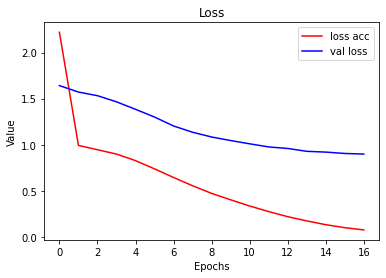

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='loss acc')
plt.plot(epochs, val_loss, 'b', label='val loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.show()

# **Model Plot**

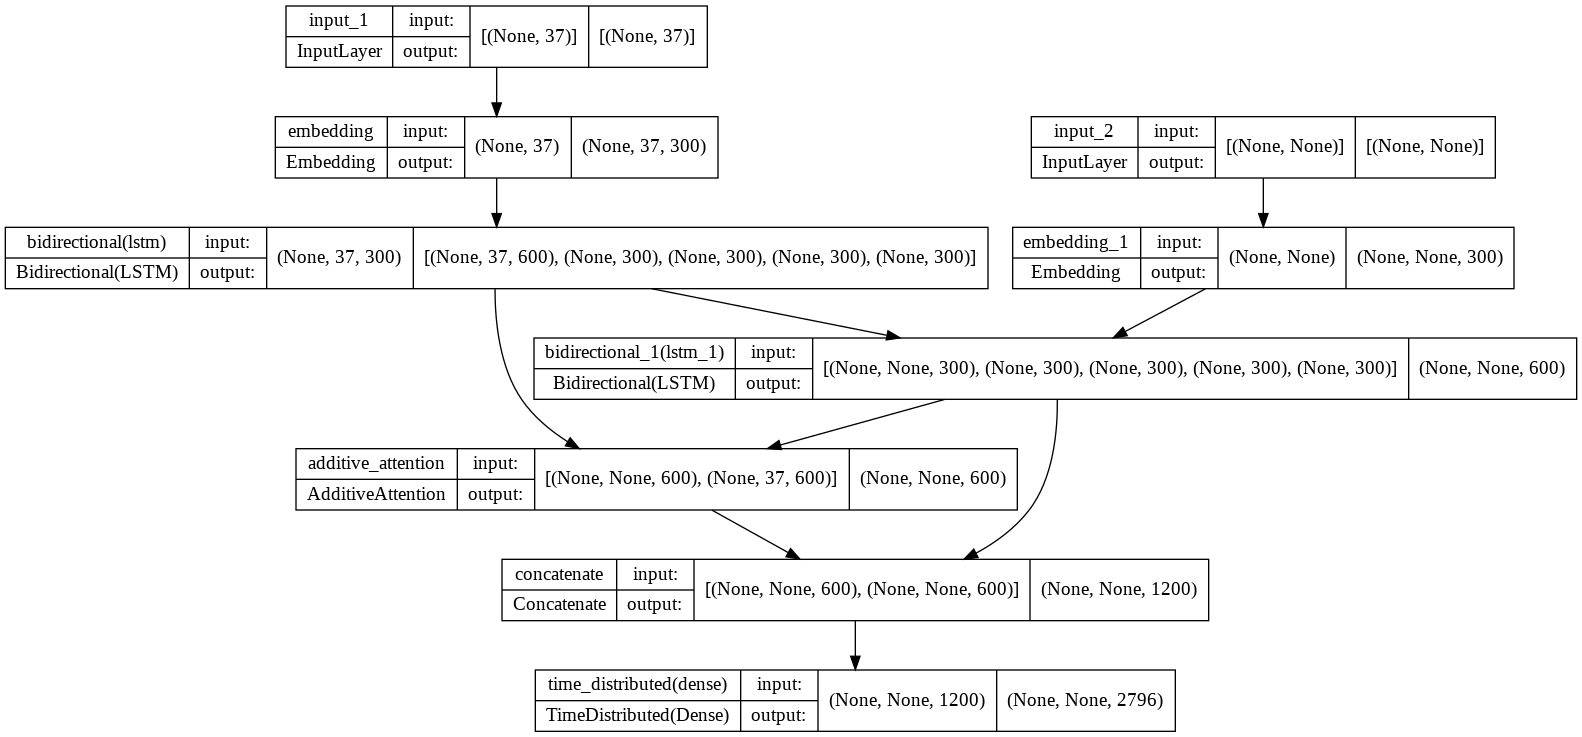

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Save Model**

In [ ]:
model.save('BackupPlan.h5')